....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................Total time: 427.3


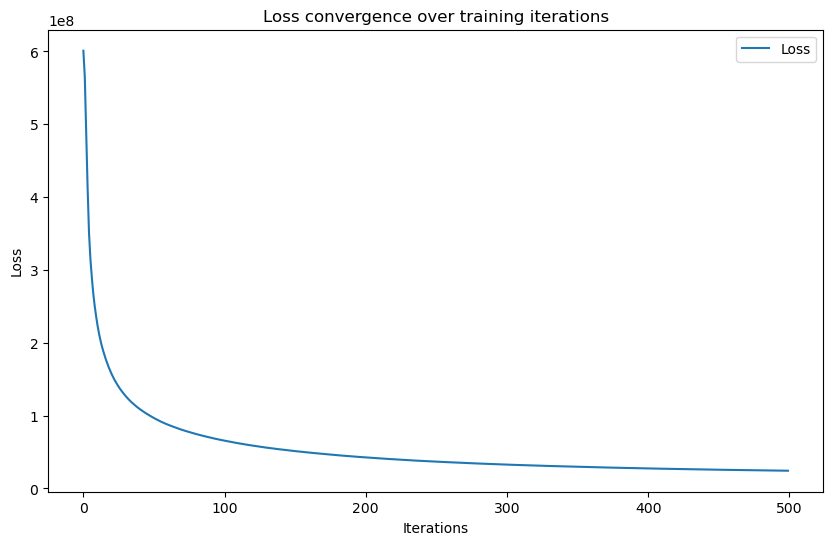

In [3]:
def NST(content_img, style_img):

    import tensorflow as tf
    import numpy as np
    import PIL.Image
    import matplotlib.pyplot as plt

    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

    content_layers = ['block5_conv2'] 
    style_layers = ['block1_conv1',
                    'block2_conv1',
                    'block3_conv1',
                    'block4_conv1',
                    'block5_conv1']

    num_content_layers = len(content_layers)
    num_style_layers = len(style_layers)

    def load_img(path_to_img):
        max_dim = 512
        img = tf.io.read_file(path_to_img)
        img = tf.image.decode_image(img, channels=3)
        img = tf.image.convert_image_dtype(img, tf.float32)

        shape = tf.cast(tf.shape(img)[:-1], tf.float32)
        long_dim = max(shape)
        scale = max_dim / long_dim

        new_shape = tf.cast(shape * scale, tf.int32)
        img = tf.image.resize(img, new_shape)
        img = img[tf.newaxis, :]
        return img

    def vgg_layers(layer_names):
        
        vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
        vgg.trainable = False
        outputs = [vgg.get_layer(name).output for name in layer_names]
        model = tf.keras.Model([vgg.input], outputs)
        return model

    def gram_matrix(input_tensor):
        
        result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
        input_shape = tf.shape(input_tensor)
        num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
        return result / (num_locations)

    class StyleContentModel(tf.keras.models.Model):
        def __init__(self, style_layers, content_layers):
            super(StyleContentModel, self).__init__()
            self.vgg = vgg_layers(style_layers + content_layers)
            self.style_layers = style_layers
            self.content_layers = content_layers
            self.num_style_layers = len(style_layers)
            self.vgg.trainable = False

        def call(self, inputs):
            
            inputs = inputs * 255.0
            preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
            outputs = self.vgg(preprocessed_input)
            style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                            outputs[self.num_style_layers:])

            style_outputs = [gram_matrix(style_output)
                            for style_output in style_outputs]

            content_dict = {content_name: value
                            for content_name, value
                            in zip(self.content_layers, content_outputs)}

            style_dict = {style_name: value
                        for style_name, value
                        in zip(self.style_layers, style_outputs)}

            return {'content': content_dict, 'style': style_dict}

    def style_content_loss(outputs, style_targets, content_targets):
        style_outputs = outputs['style']
        content_outputs = outputs['content']
        style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2)
                            for name in style_outputs.keys()])
        style_loss *= 1e-2 / num_style_layers

        content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2)
                                for name in content_outputs.keys()])
        content_loss *= 1e5/ num_content_layers
        loss = style_loss + content_loss
        return loss

    content_path = content_img
    style_path = style_img
    content_image = load_img(content_path)
    style_image = load_img(style_path)

    extractor = StyleContentModel(style_layers, content_layers)
    style_targets = extractor(style_image)['style']
    content_targets = extractor(content_image)['content']

    opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

    @tf.function()
    def train_step(image):
        with tf.GradientTape() as tape:
            outputs = extractor(image)
            loss = style_content_loss(outputs, style_targets, content_targets)
        grad = tape.gradient(loss, image)
        opt.apply_gradients([(grad, image)])
        image.assign(tf.clip_by_value(image, 0.0, 1.0))
        return loss

    image = tf.Variable(content_image)

    def tensor_to_image(tensor):
        tensor = tensor * 255
        tensor = np.array(tensor, dtype=np.uint8)
        if np.ndim(tensor) > 3:
            assert tensor.shape[0] == 1
            tensor = tensor[0]
        return PIL.Image.fromarray(tensor)

    import time
    start = time.time()

    epochs = 5
    steps_per_epoch = 100
    step = 0
    all_losses = []

    for n in range(epochs):
        for m in range(steps_per_epoch):
            step += 1
            loss = train_step(image)
            all_losses.append(loss.numpy())
            print(".", end='', flush=True)
        

    end = time.time()
    print("Total time: {:.1f}".format(end-start))

    # Plot the loss
    plt.figure(figsize=(10, 6))
    plt.plot(all_losses, label='Loss')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.title('Loss convergence over training iterations')
    plt.legend()
    plt.show()

    result_image = tensor_to_image(image)
    result_image.save('stylised_image.png')

NST('IMG_7258.JPG', 'edtaonisl.jpg')
